Set subject model.

In [1]:
#must be unique.
model_name = 'Final_Model_1'
epoch_select = 1000

Imports and model init

In [8]:
#imports

import torch
import matplotlib.pyplot as plt
import numpy as np
import time, os, pickle
import pandas as pd


import init
import loader
import visualisation
import parameters
import ipynb_utils
import sys
from serial import RNN
from b_vae import B_VAE
from autoencoders import vae
import matplotlib.colors as colors
import matplotlib.cm as cmx
sys.path.append('../../libs/')
import shjnn

# Initalize Model




# Load the model
saves_folder = "saves"
model_subfolder = None

if os.path.exists(saves_folder):
    for subfolder in os.listdir(saves_folder):
        subfolder_path = os.path.join(saves_folder, subfolder)
        if os.path.isdir(subfolder_path) and model_name in subfolder:
            model_subfolder = os.path.join(subfolder_path, "model")
            break

# Check for Pickle and PTH files
pickle_file = None
pth_files = []
for file in os.listdir(model_subfolder):
    if file.endswith(".pkl"):
        pickle_file = os.path.join(model_subfolder, file)
        print(f"(1/4) Found Config file: {pickle_file}")
        
    elif file.endswith(".pth"):
        pth_file = os.path.join(model_subfolder, file)
        pth_files.append(pth_file)
if not pickle_file or not pth_files:
    print(f"Pickle file or PTH file not found in '{model_subfolder}'.")
    raise FileNotFoundError(f"Pickle file or PTH file not found in '{model_subfolder}'.")

if pth_files:
    print(f"(2/4) Found Model Saves")
# Load the model configuration
loaded = None
with open(pickle_file, 'rb') as f:
    try:
        loaded = pickle.load(f)
    except EOFError:
        pass
assert len(loaded) == 17


parameters.dataset = loaded[0]
parameters.dataset_PV = loaded[1]
parameters.trainer = loaded[2]
parameters.model = loaded[3]
parameters.rnn = loaded[4]
parameters.b_vae = loaded[5]
parameters.load_check = loaded[6]
parameters.model_params = loaded[7]
parameters.vae_params = loaded[8]
parameters.records = loaded[9]
parameters.device = loaded[10]
parameters.amp = loaded[11]
parameters.freq = loaded[12]
parameters.adaptive_training = loaded[13]
parameters.save = loaded[14]
parameters.split = loaded[15]
parameters.gridsearch = loaded[16]

assert parameters.load_check == True
print(f"(3/4) Loaded Config")

#load the model.
model_params = parameters.model_params
dev = torch.device(parameters.device)
if epoch_select is None:
    path = pth_files[-1]  # Use the last file in the list
else:
    path = [f for f in pth_files if f"{epoch_select}" in f]
    if not path:
        raise FileNotFoundError(f"No PTH file found for epoch {epoch_select}.")
    path = path[0]
assert model_params['func'] is not None
try:
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])
except (ImportError, AttributeError):
    pass
shjnn.load_state(path, model_params['func'], model_params['rec'], decoder = model_params['dec'], optimizer = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)
print(f"(4/4) Loaded Model from {path}")

print("---Success--- Model and parameters loaded successfully.")

(1/4) Found Config file: saves/20250529-174140_Final_Model_1_/model/parameters.pkl
(2/4) Found Model Saves
(3/4) Loaded Config
(4/4) Loaded Model from saves/20250529-174140_Final_Model_1_/model/save_model_ckpt_1000.pth
---Success--- Model and parameters loaded successfully.


In [12]:
# check performance

parameters.model.eval(parameters.model_params, parameters.dataset)

logs: b_vae: eval: evaluating over 150 samples.
logs: b_vae: eval: batch 1/10, avg loss: 0.695969
logs: b_vae: eval: batch 2/10, avg loss: 0.843598
logs: b_vae: eval: batch 3/10, avg loss: 0.976717
logs: b_vae: eval: batch 4/10, avg loss: 0.940352
logs: b_vae: eval: batch 5/10, avg loss: 1.081175
logs: b_vae: eval: batch 6/10, avg loss: 0.950232
logs: b_vae: eval: batch 7/10, avg loss: 0.876646
logs: b_vae: eval: batch 8/10, avg loss: 1.242888
logs: b_vae: eval: batch 9/10, avg loss: 0.883292
logs: b_vae: eval: batch 10/10, avg loss: 0.772912
logs: b_vae: eval: mean loss over 150 samples: 0.9366091533501943 at epoch 1000.


np.float64(0.9366091533501943)

Function to get sweeps through the dataset along a specific axis.

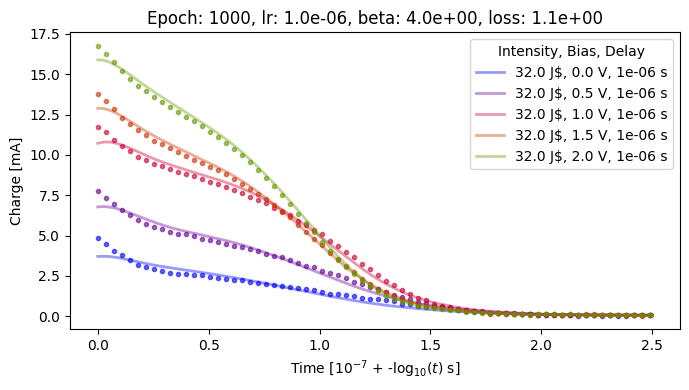

In [14]:
# Run model inference and visualisation along different parameters

# select models to plot ('intensity', 'voltage', or 'delay')
plot_models = ipynb_utils.get_sweep_index(122, 'voltage')  # Example: sweep based on intensity from the first index

parameters.model_params['plot'] = plot_models
visualisation.display_random_fit(parameters.model_params, parameters.dataset, show=True, save=False, random_samples=False)


Latent Init

In [5]:
latent, all = ipynb_utils.get_latent_vectors(model_params, parameters.dataset, traj_idx=None)

Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


Sweep latent dimensions

---Visualising Latent Dimension 0---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


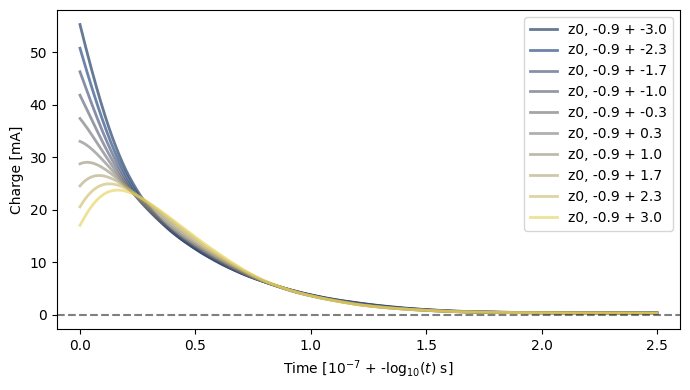

---Visualising Latent Dimension 1---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


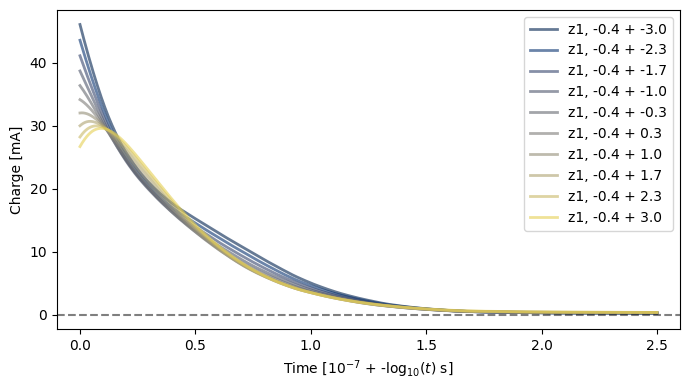

---Visualising Latent Dimension 2---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


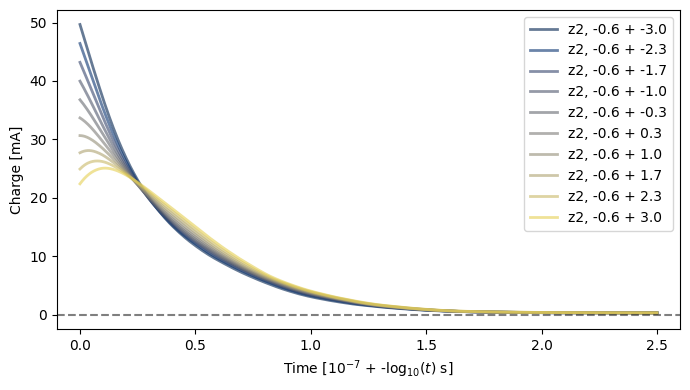

---Visualising Latent Dimension 3---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


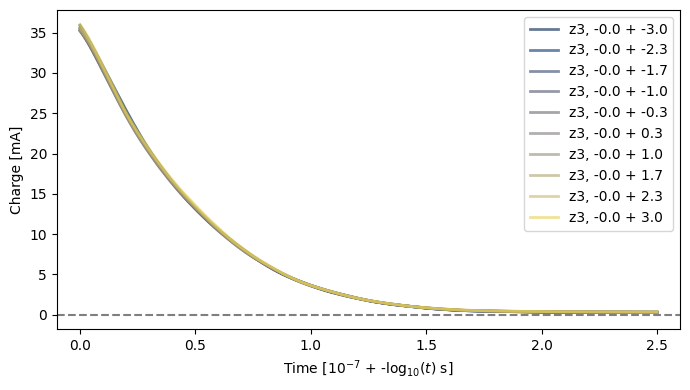

---Visualising Latent Dimension 4---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


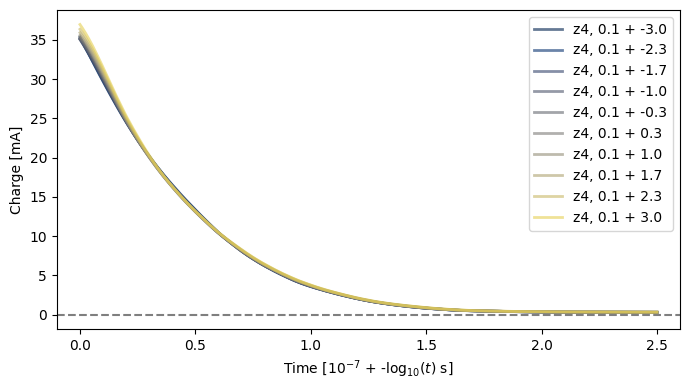

---Visualising Latent Dimension 5---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


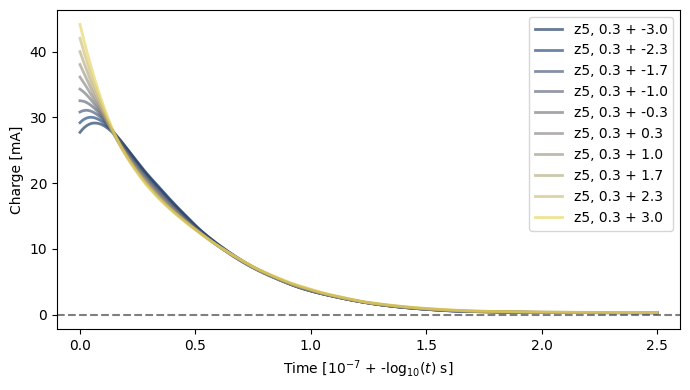

---Visualising Latent Dimension 6---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


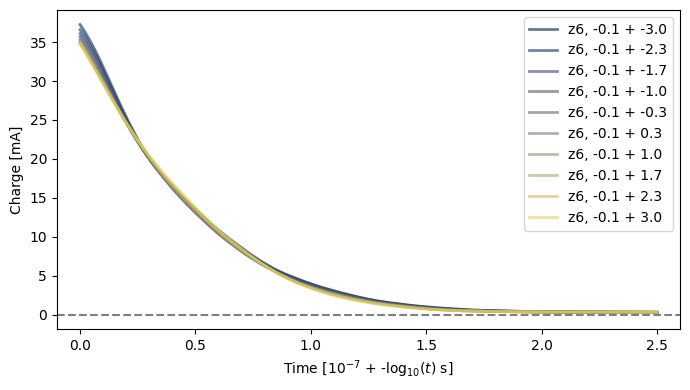

---Visualising Latent Dimension 7---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


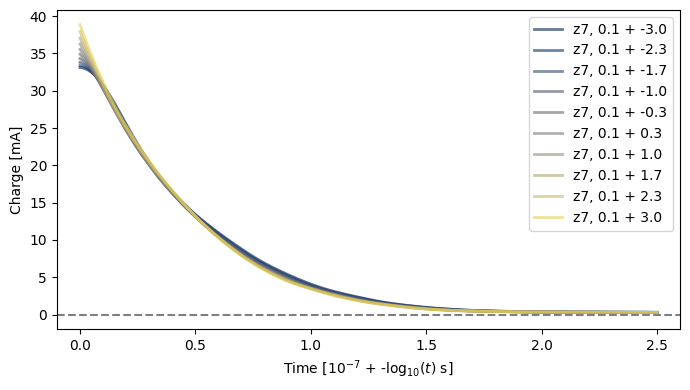

---Visualising Latent Dimension 8---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


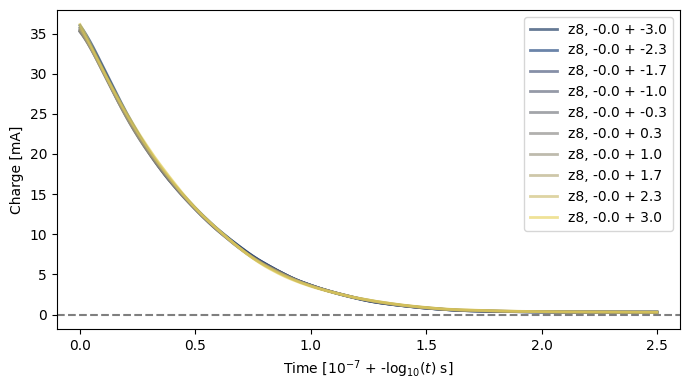

---Visualising Latent Dimension 9---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


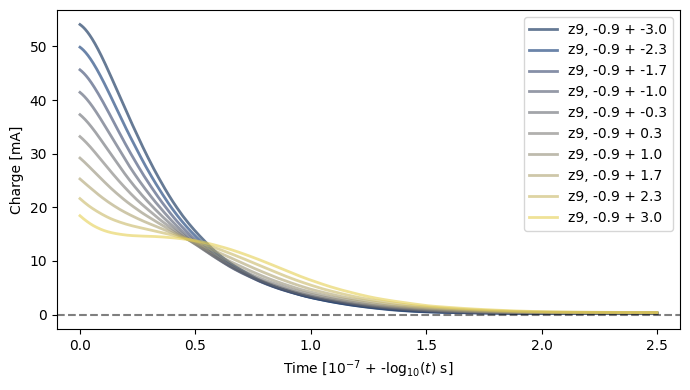

---Visualising Latent Dimension 10---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


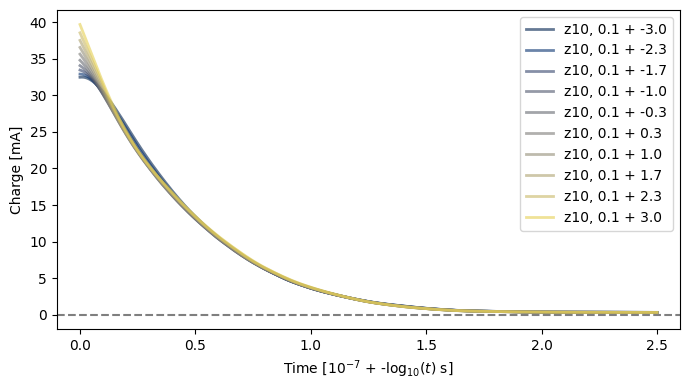

---Visualising Latent Dimension 11---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


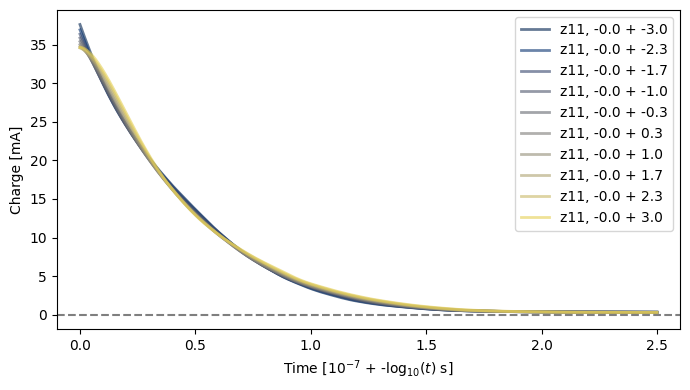

---Visualising Latent Dimension 12---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


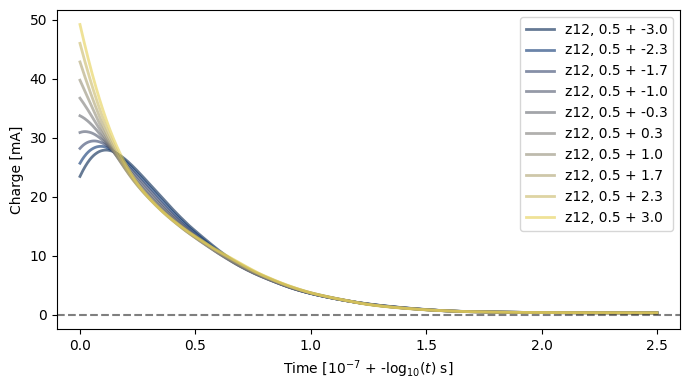

---Visualising Latent Dimension 13---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


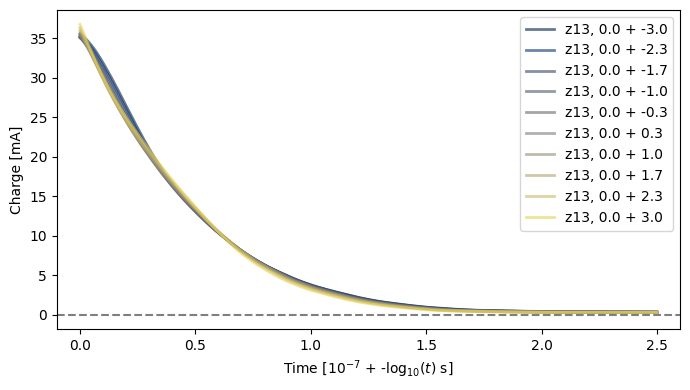

---Visualising Latent Dimension 14---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


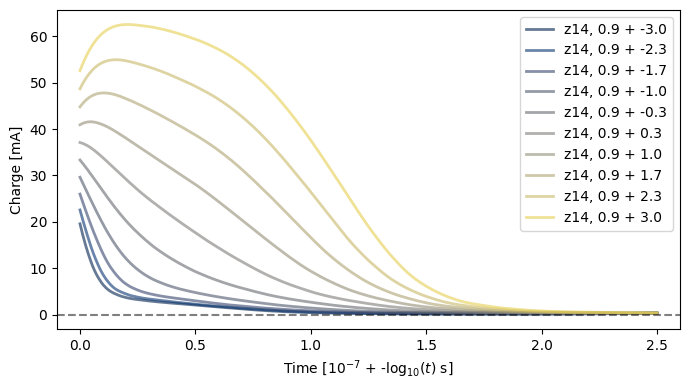

---Visualising Latent Dimension 15---
Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


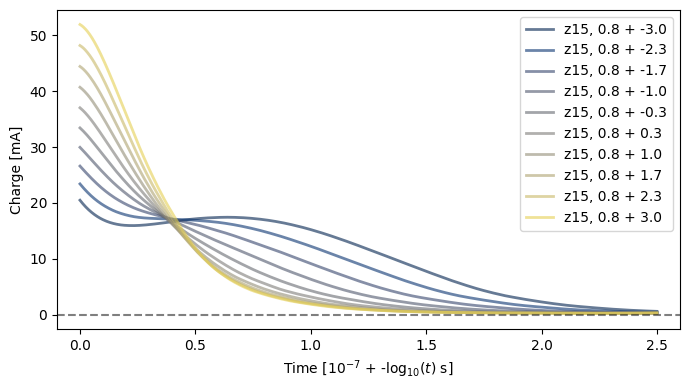

In [ ]:
for dim_idx in range(model_params['latent_dim']):
    print(f"---Visualising Latent Dimension {dim_idx}---")
    ipynb_utils.sweep_latent_adaptive(parameters.model_params, parameters.dataset, dim_idx, latent, all, save=False, show=True)

In [14]:
# Test the time evolved sweep function
dim_idx = 0  # Example latent dimension
timesteps_of_interest = [0, 100, 200, 300, 400, 500, 600, 900, 999]  # Example timesteps to analyze (0 - 999)

print(f"---Visualising Time-Evolved Latent Dimension {dim_idx}---")
visualisation.time_evolved_sweep(
    parameters.model_params, 
    parameters.dataset, 
    dim_idx, 
    timesteps_of_interest, 
    save=False, 
    show=True
)

---Visualising Time-Evolved Latent Dimension 0---


KeyboardInterrupt: 

Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


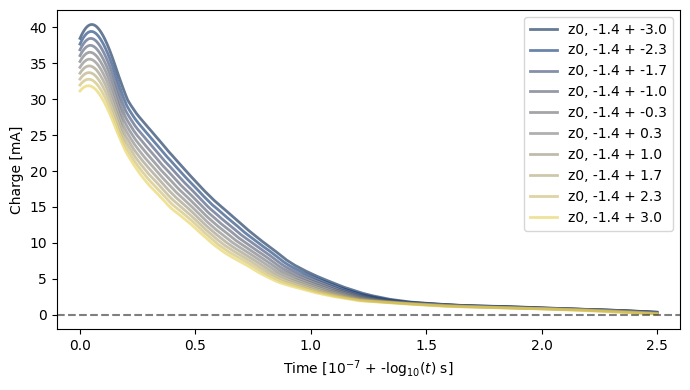

In [ ]:
visualisation.sweep_latent_adaptive(parameters.model_params, parameters.dataset, 0, save=False, show=True)

In [17]:

def latent_trajectory(all_latent_vectors, sample_list=None, show=True, save=False, save_path=None):
    """
    Plot how every latent dimension's mean evolves over timesteps.
    
    Parameters
    ----------
    all_latent_vectors : numpy.ndarray
        Array of shape (n_samples, n_timesteps, n_latent_dims) containing
        latent vectors for all samples and timesteps
    sample_list : list or None, optional
        List of sample indices to include in mean calculation. 
        If None, uses all samples. Default is None.
    show : bool, optional
        Whether to display the plot. Default is True.
    save : bool, optional
        Whether to save the plot. Default is False.
    save_path : str or None, optional
        Path to save the plot. If None and save=True, uses default path.
        
    Returns
    -------
    None
        Creates and optionally displays/saves the plot
    """
    
    # Select samples to include in mean calculation
    if sample_list is None:
        selected_vectors = all_latent_vectors  # Use all samples
    else:
        selected_vectors = all_latent_vectors[sample_list]  # Use specified samples
    
    # Calculate mean across samples for each timestep and latent dimension
    # Shape: (n_timesteps, n_latent_dims)
    mean_latent_trajectory = np.mean(selected_vectors, axis=0)
    
    n_timesteps, n_latent_dims = mean_latent_trajectory.shape
    timesteps = np.arange(n_timesteps)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create colormap for different latent dimensions
    colors_list = plt.cm.tab20(np.linspace(0, 1, n_latent_dims))
    
    # Plot each latent dimension
    for dim in range(n_latent_dims):
        ax.plot(timesteps, mean_latent_trajectory[:, dim], 
               label=f'Latent Dim {dim}', 
               color=colors_list[dim], 
               linewidth=2, 
               alpha=0.8)
    
    # Formatting
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Mean Latent Value')
    ax.set_title('Evolution of Mean Latent Dimensions Over Time')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add info about sample selection
    if sample_list is None:
        sample_info = f"All samples (n={len(all_latent_vectors)})"
    else:
        sample_info = f"Selected samples (n={len(sample_list)})"
    
    ax.text(0.02, 0.98, sample_info, transform=ax.transAxes, 
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Save if requested
    if save:
        if save_path is None:
            save_path = 'latent_trajectory_evolution.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    # Show if requested
    if show:
        plt.show()
    
    print(f"Plotted {n_latent_dims} latent dimensions over {n_timesteps} timesteps")
    if sample_list is not None:
        print(f"Used samples: {sample_list}")

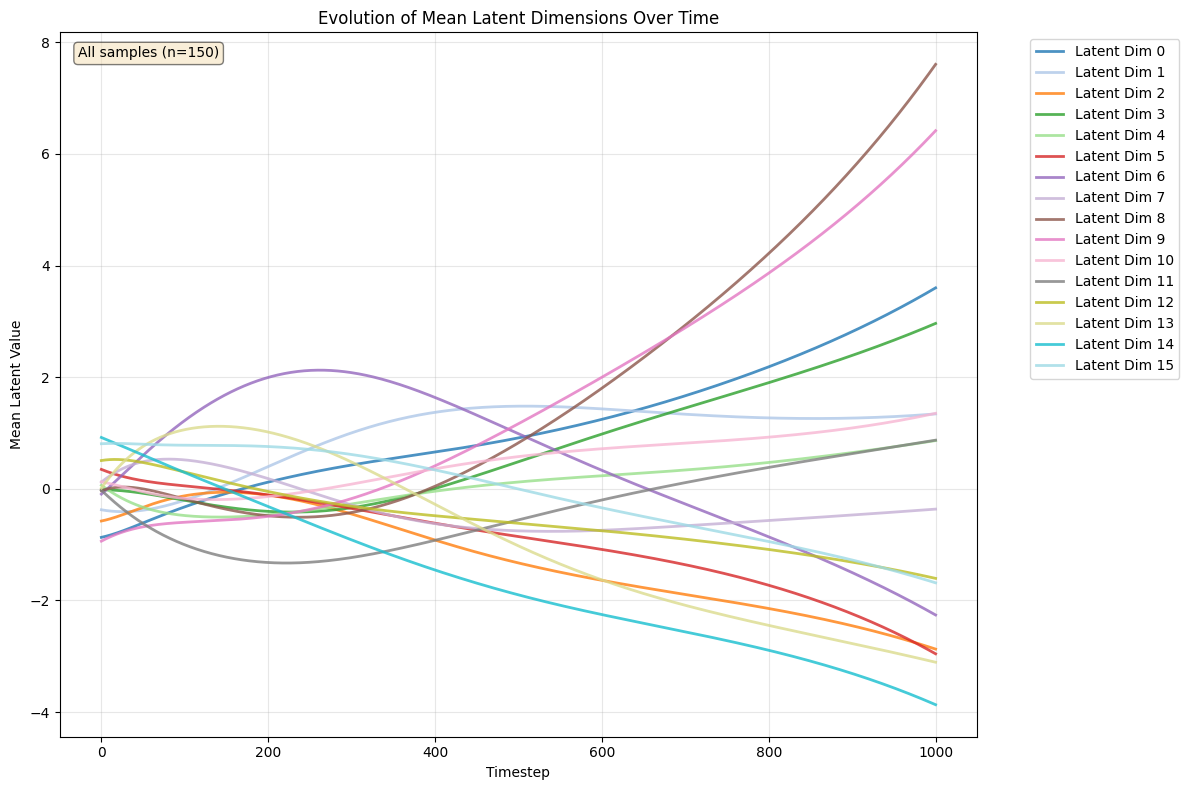

Plotted 16 latent dimensions over 1000 timesteps


In [24]:
# Plot latent trajectory evolution
# Show how all latent dimensions evolve over time

# Using all samples
latent_trajectory(all, sample_list=None, show=True, save=False)

# Example: Using only specific samples (e.g., first 10 samples)
# ipynb_utils.latent_trajectory(all, sample_list=list(range(10)), show=True, save=False)

In [ ]:
def latent_trajectory(all_latent_vectors, sample_list=None):
    

UMAP Encoding of the latent space.


/mnt/c/vscode/thesis/ML_charge_modeling/.wsl-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/c/vscode/thesis/ML_charge_modeling/.wsl-venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


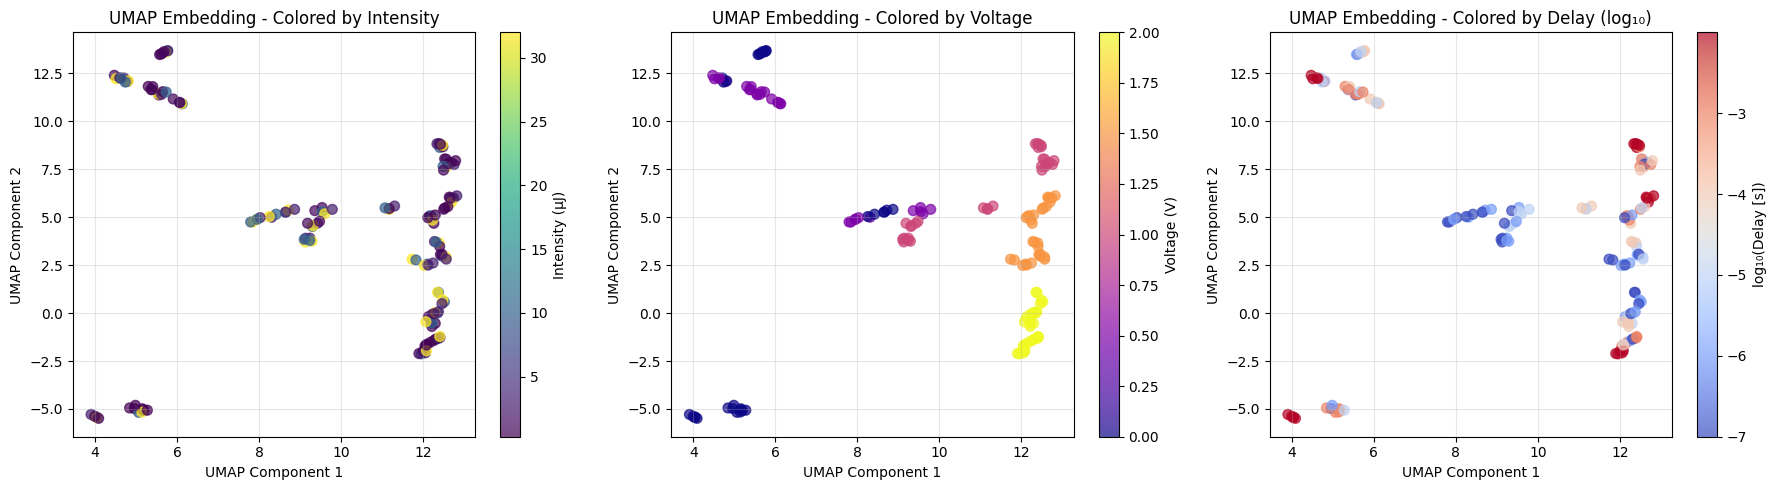

Original latent space shape: (150, 16)
UMAP embedding shape: (150, 2)
Intensity range: 0.30 to 32.00 μJ
Voltage range: 0.00 to 2.00 V
Delay range: 1.00e-07 to 1.00e-02 s
Log delay range: -7.0 to -2.0
Unique delay values: ['1.0e-07', '1.0e-06', '1.0e-05', '1.0e-04', '1.0e-03', '1.0e-02']


In [15]:
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the latent vectors
scaler = StandardScaler()
latent_scaled = scaler.fit_transform(latent)

# Apply UMAP dimensionality reduction
reducer = UMAP(n_components=2, random_state=0)
embedding = reducer.fit_transform(latent_scaled)

# Get metadata values for coloring
metadata = parameters.dataset['y'].cpu().numpy()  
intensities = [meta[0] for meta in metadata]  # INTENSITY = 0
voltages = [meta[1] for meta in metadata]     # VOLTAGE = 1
delays = [meta[2] for meta in metadata]       # DELAY = 2

# Convert delays to log scale for better visualization
log_delays = [np.log10(delay) if delay > 0 else np.nan for delay in delays]

# Create 3 subplots for intensity, voltage, and delay
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Colored by intensity
scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=intensities, cmap='viridis', alpha=0.7, s=50)
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].set_title('UMAP Embedding - Colored by Intensity')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='Intensity (μJ)')

# Plot 2: Colored by voltage
scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=voltages, cmap='plasma', alpha=0.7, s=50)
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].set_title('UMAP Embedding - Colored by Voltage')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Voltage (V)')

# Plot 3: Colored by delay (log scale)
scatter3 = axes[2].scatter(embedding[:, 0], embedding[:, 1], c=log_delays, cmap='coolwarm', alpha=0.7, s=50)
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')
axes[2].set_title('UMAP Embedding - Colored by Delay (log₁₀)')
axes[2].grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[2], label='log₁₀(Delay [s])')

plt.tight_layout()
plt.show()

print(f"Original latent space shape: {latent.shape}")
print(f"UMAP embedding shape: {embedding.shape}")
print(f"Intensity range: {min(intensities):.2f} to {max(intensities):.2f} μJ")
print(f"Voltage range: {min(voltages):.2f} to {max(voltages):.2f} V") 
print(f"Delay range: {min([d for d in delays if d > 0]):.2e} to {max(delays):.2e} s")
print(f"Log delay range: {min([d for d in log_delays if not np.isnan(d)]):.1f} to {max([d for d in log_delays if not np.isnan(d)]):.1f}")

# Show unique delay values for reference
unique_delays = sorted(list(set([d for d in delays if d > 0])))
print(f"Unique delay values: {[f'{d:.1e}' for d in unique_delays]}")